# 1 Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construiré un modelo para dicha predicción.

## 2 Preparación

In [1]:
# cargar librerías

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import seaborn as sns
import math
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor 
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels.api as sm
from tqdm import tqdm
import itertools

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
df = data.copy()

In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
# Convierto valores en datetime y los transformo en el index

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)


## 3 Análisis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:xlabel='datetime'>

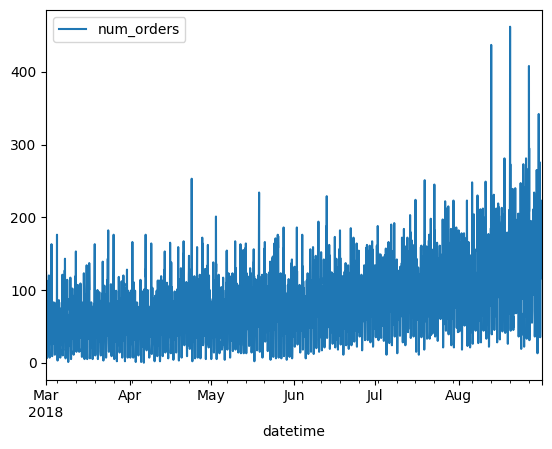

In [8]:
#  Ordeno los datos y hago el resampleo

df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.plot()

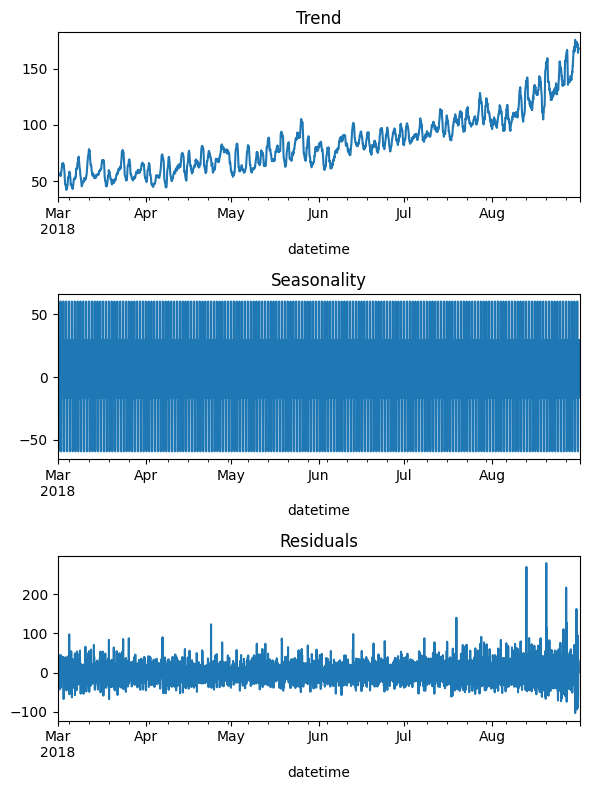

In [9]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [10]:
print(df.index.is_monotonic)


True


<AxesSubplot:xlabel='datetime'>

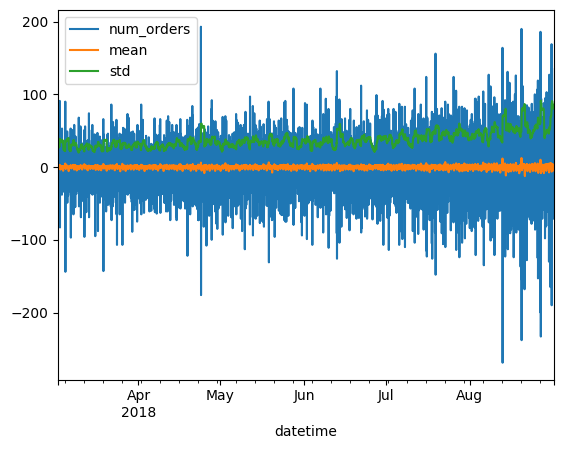

In [11]:
df -= df.shift()
df['mean'] = df['num_orders'].rolling(30).mean()
df['std'] = df['num_orders'].rolling(30).std()
df = df.dropna()
df.plot()  

## 4 Formación

In [12]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 06:00:00 2018-08-13 16:00:00
2018-08-13 17:00:00 2018-08-31 23:00:00


## 5 Prueba

In [13]:
print('Pedidos de taxis pronosticado:', test['num_orders'].median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('RECM:',  mse(test, pred_median) ** 0.5)

Pedidos de taxis pronosticado: 2.0
RECM: 48.28858164693585


In [14]:
print('Pedidos de taxis pronosticado la siguiente hora:', test['num_orders'].median())

pred_previous = test.shift() 
pred_previous.iloc[0] = train.iloc[-1]
print('RECM:',  mse(test, pred_previous) ** 0.5) 

Pedidos de taxis pronosticado la siguiente hora: 2.0
RECM: 53.76492840834796


In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())


make_features(df, 1, 1)
print(df.head())

                     num_orders      mean        std  year  month  day  \
datetime                                                                 
2018-03-02 06:00:00         0.0 -3.766667  29.120065  2018      3    2   
2018-03-02 07:00:00        -4.0 -2.600000  28.350759  2018      3    2   
2018-03-02 08:00:00        39.0 -0.833333  29.252861  2018      3    2   
2018-03-02 09:00:00        -1.0 -0.700000  29.242329  2018      3    2   
2018-03-02 10:00:00         9.0  0.366667  28.983329  2018      3    2   

                     dayofweek  lag_1  rolling_mean  
datetime                                             
2018-03-02 06:00:00          4    NaN           NaN  
2018-03-02 07:00:00          4    0.0           0.0  
2018-03-02 08:00:00          4   -4.0          -4.0  
2018-03-02 09:00:00          4   39.0          39.0  
2018-03-02 10:00:00          4   -1.0          -1.0  


/tmp/ipykernel_371/4052947585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data.index.year
/tmp/ipykernel_371/4052947585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data.index.month
/tmp/ipykernel_371/4052947585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [16]:
df= df.dropna()
print(df.head())

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

                     num_orders      mean        std  year  month  day  \
datetime                                                                 
2018-03-02 07:00:00        -4.0 -2.600000  28.350759  2018      3    2   
2018-03-02 08:00:00        39.0 -0.833333  29.252861  2018      3    2   
2018-03-02 09:00:00        -1.0 -0.700000  29.242329  2018      3    2   
2018-03-02 10:00:00         9.0  0.366667  28.983329  2018      3    2   
2018-03-02 11:00:00        37.0  2.833333  28.842119  2018      3    2   

                     dayofweek  lag_1  rolling_mean  
datetime                                             
2018-03-02 07:00:00          4    0.0           0.0  
2018-03-02 08:00:00          4   -4.0          -4.0  
2018-03-02 09:00:00          4   39.0          39.0  
2018-03-02 10:00:00          4   -1.0          -1.0  
2018-03-02 11:00:00          4    9.0           9.0  


In [17]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print("RECM para el conjunto de entrenamiento:", mse(target_train, pred_train) ** 0.5)

print("RECM para el conjunto de prueba:", mse(target_test, pred_test) ** 0.5)

RECM para el conjunto de entrenamiento: 33.83275637564981
RECM para el conjunto de prueba: 56.35966048231773


In [18]:
# LightGBM
# búsqueda de hiperparámetros
# Creé una instancia de LightGBM Regressor con recm. 
model = LGBMRegressor(learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    n_estimators=100,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    metric='rmse') 
  
# Entrenar el modelo con el conjunto de entrenamiento. 
model.fit(features_train, target_train)

# Hacer predicciones con los datos de prueba junto con su tiempo de ejecución. 

val_t_predictions = model.predict(features_test)
mse_t = mse(target_test, val_t_predictions)
print("RECM test = ", mse_t ** 0.5 )

RECM test =  60.3900070537588


In [19]:
# Ver si la serie es estacionaria (dado el resultado sí lo es)

result = adfuller(df['num_orders'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -15.739395
p-value: 0.000000


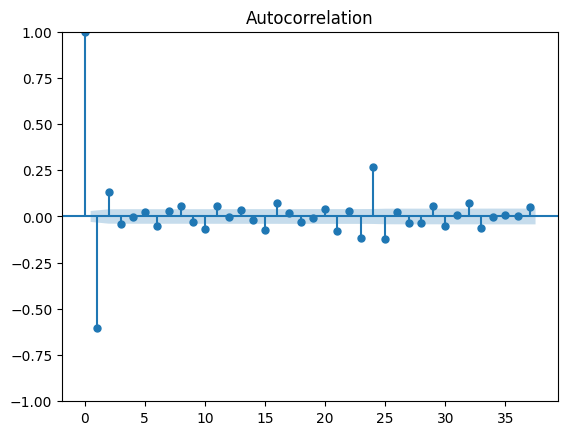

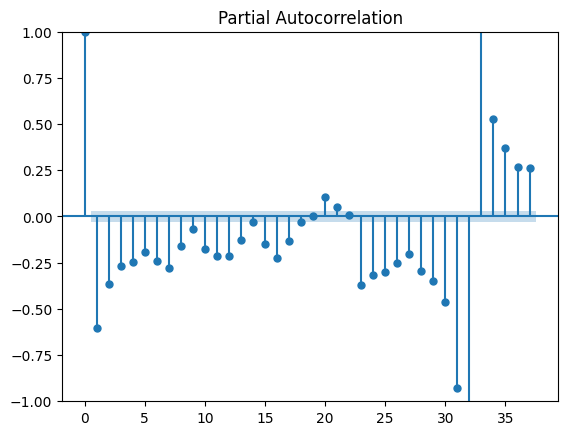

In [20]:
# Plot ACF
plot_acf(df['num_orders'].diff().dropna())
plt.show()

# Plot PACF
plot_pacf(df['num_orders'].diff().dropna())
plt.show()

In [21]:
# Define el modelo ARIMA

p= 19
d= 0
q= 5

model = ARIMA(train['num_orders'], order=(p, d, q))
model_fit = model.fit()

# Realiza predicciones
predictions = model_fit.forecast(steps=len(features_test))

# Calcula RMSE
rmse = np.sqrt(mse(target_test, predictions))
print(f'RMSE: {rmse}')

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 58.859848648388855


In [22]:
# Define the p, d, q and P, D, Q parameters to take any value between 0 and 2
p = d = q = range(0, 1)
pdq = list(itertools.product(p, d, q))

# Seasonal parameters
seasonal_pdq = [(1, 0, 1, 24) for x in pdq]

best_aic = np.inf
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(df['num_orders'],
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
        except:
            continue

print(f'Best ARIMA parameters: {best_params}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97902D+00    |proj g|=  4.32559D-01


 This problem is unconstrained.


  ys=-2.466E-02  -gs= 5.583E-02 BFGS update SKIPPED

At iterate    5    f=  4.85838D+00    |proj g|=  5.19049D-01

At iterate   10    f=  4.85410D+00    |proj g|=  6.50038D-03

At iterate   15    f=  4.85368D+00    |proj g|=  1.05182D-01

At iterate   20    f=  4.84634D+00    |proj g|=  3.33414D-01

At iterate   25    f=  4.83802D+00    |proj g|=  1.14494D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     46      1     1     0   1.584D-05   4.838D+00
  F =   4.8380129519828863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best ARIMA parameters: ((0, 0, 0), (1, 0, 1, 24))


In [24]:

# Fit model with best parameters
model = SARIMAX(train['num_orders'], order=best_params[0], seasonal_order=best_params[1])
model_fit = model.fit()

# Forecast
predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = np.sqrt(mse(test['num_orders'], predictions))
print(f'RMSE: {rmse}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90410D+00    |proj g|=  2.34627D-01


 This problem is unconstrained.



At iterate    5    f=  4.83479D+00    |proj g|=  7.87896D-02

At iterate   10    f=  4.78104D+00    |proj g|=  1.60056D-02

At iterate   15    f=  4.77335D+00    |proj g|=  8.71104D-04

At iterate   20    f=  4.77264D+00    |proj g|=  1.64881D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   1.649D-06   4.773D+00
  F =   4.7726411059224372     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE: 49.402224715375475
